# Mathematico - Game Properties


This notebooks aims to present the general properties of the game Mathematico, especially 
from the point of implementing a better strategy, or `Player`.

## Installation

In [1]:
!git clone --quiet https://github.com/balgot/mathematico.git tmp || git -C tmp pull
!cd tmp/game && python -m pip install --quiet . 
!rm -rf tmp

import mathematico
from mathematico import Arena, Board, Mathematico
from mathematico import Player, HumanPlayer, RandomPlayer, SimulationPlayer

In [2]:
%pip install -q seaborn pandas matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Note: you may need to restart the kernel to use updated packages.


## Properties

### Number of states

As each number `1-13` is present up to 4 times in the random deck, the full game contains of

In [3]:
from math import factorial

# 14 - each cell can be empty
states = (factorial(14) // factorial(8)) ** 4  *  factorial(8)
print(states, "~", f"{states:.2E}")

881194622010120281338675200000 ~ 8.81E+29


### Expected Score

Using `RandomPlayer`, we will estimate the expected score using random game play as the baseline for other comparisons.

In [4]:
N_PLAYERS = 5

import random
random.seed(0)

players = [RandomPlayer() for _ in range(N_PLAYERS)]
arena = Arena()
for p in players:
    arena.add_player(p)

We will simulate a number of games and analyze the achieved scores.

In [5]:
N_ROUNDS = 10_000
scores = arena.run(seed=0, rounds=N_ROUNDS)
data = {}
for i in range(len(players)):
    data[f"player_{i}"] = scores[i]
    
df = pd.DataFrame(data=data)
df.describe()

Steps run: 10000	Elapsed time: 28.864091634750366


,player_0,player_1,player_2,player_3,player_4
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,83.743000,83.716000,83.425000,84.271000,83.808000
std,30.764827,30.546434,29.454476,31.167061,30.391306
min,0.000000,10.000000,10.000000,0.000000,10.000000
25%,60.000000,60.000000,60.000000,60.000000,60.000000
50%,80.000000,80.000000,80.000000,80.000000,80.000000
75%,100.000000,100.000000,100.000000,100.000000,100.000000
max,370.000000,320.000000,290.000000,350.000000,300.000000


As can be seen, the average random score is about 84 points, with the maximum being around 400 points, and the minimum 0 points.

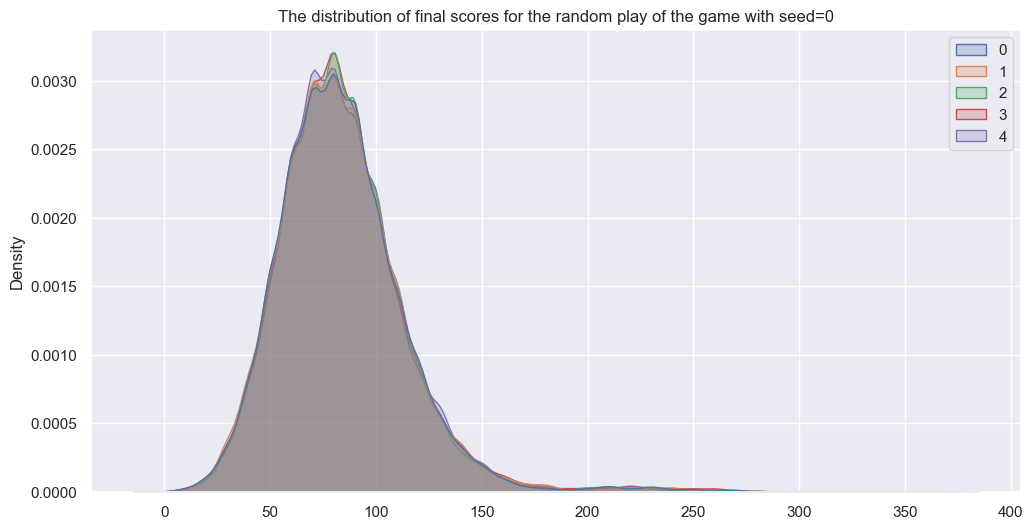

In [6]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=scores, fill=True)
plt.title("The distribution of final scores for the random play of the game with seed=0");

## Symmetries

Since the order of cells is irrelevant for scoring the particular line, and both diagonals are treated equally, the game of Mathematico has a number of symmetries:

* each rotation for a particular position (4)
* horizontal a vertical flips (2)
* special swap one-for-one, when we swap the outer and inner values (01, 03, 14, 34) (e.g. 01):

<div style="display: flex; flex-direction: row">
    <pre>
+--+--+--+--+--+
| 3| 1| 7| 7| 2|
+--+--+--+--+--+
| 2| 5| 6|13| 6|
+--+--+--+--+--+
|13|10| 2|10| 3|
+--+--+--+--+--+
| 9|11| 1|11| 4|
+--+--+--+--+--+
| 3| 8| 6|10| 5|
+--+--+--+--+--+
    </pre>
    <p style="padding:1em">  --(swap rows 0, 1)-->  </p>
    <pre>
+--+--+--+--+--+
| 2| 5| 6|13| 6|
+--+--+--+--+--+
| 3| 1| 7| 7| 2|
+--+--+--+--+--+
|13|10| 2|10| 3|
+--+--+--+--+--+
| 9|11| 1|11| 4|
+--+--+--+--+--+
| 3| 8| 6|10| 5|
+--+--+--+--+--+
    </pre>
    <p style="padding:1em">  --(fix cols 0, 1)-->  </p>
    <pre>
+--+--+--+--+--+
| 5| 2| 6|13| 6|
+--+--+--+--+--+
| 1| 3| 7| 7| 2|
+--+--+--+--+--+
|10|13| 2|10| 3|
+--+--+--+--+--+
|11| 9| 1|11| 4|
+--+--+--+--+--+
| 8| 3| 6|10| 5|
+--+--+--+--+--+
    </pre>
    <p style="padding:1em">  --(fix cols 4-0, 4-1)-->  </p>
    <pre>
+--+--+--+--+--+
| 5| 2| 6| 6|13|
+--+--+--+--+--+
| 1| 3| 7| 2| 7|
+--+--+--+--+--+
|10|13| 2| 3|10|
+--+--+--+--+--+
|11| 9| 1| 4|11|
+--+--+--+--+--+
| 8| 3| 6| 5|10|
+--+--+--+--+--+
    </pre>
    <p style="padding:1em">  --(fix rows 4-0, 4-1)-->  </p>
    <pre>
+--+--+--+--+--+
| 5| 2| 6| 6|13|
+--+--+--+--+--+
| 1| 3| 7| 2| 7|
+--+--+--+--+--+
|10|13| 2| 3|10|
+--+--+--+--+--+
| 8| 3| 6| 5|10|
+--+--+--+--+--+
|11| 9| 1| 4|11|
+--+--+--+--+--+
    </pre>
</div>

In [7]:
from copy import deepcopy

Board2D = list[list[int]]

def _spec_swap(board: Board2D, i, j) -> Board2D:
    """00 is identity"""
    board = deepcopy(board)
    board[i], board[j] = board[j], board[i]
    for k in range(5):
        board[k][i], board[k][j] = board[k][j], board[k][i]
        board[k][4-i], board[k][4-j] = board[k][4-j], board[k][4-i]
    board[4-i], board[4-j] = board[4-j], board[4-i]
    return board

def _vertical(board: Board2D) -> Board2D:
    board = deepcopy(board)
    return [row[::-1] for row in board]

def _horizontal(board: Board2D) -> Board2D:
    board = deepcopy(board)
    return board[::-1]

def _trans(board):
    for i in range(5):
        for j in range(i):
            board[i][j], board[j][i] = board[j][i], board[i][j]

def _rotate(board: Board2D) -> Board2D:
    # 90 degrees
    board = deepcopy(board)
    _trans(board)
    return _vertical(board)

def all_symmetries(board: Board2D) -> list[Board2D]:
    """some of them might be duplicates..."""
    assert len(board) == 5
    assert all(len(row) == 5 for row in board)
    
    board = deepcopy(board)
    result = []
    
    for i, j in [(0, 0), (0, 1), (0, 3), (0, 4), (1, 3), (1, 4), (3, 4)]:
        b = _spec_swap(board, i, j)
        for _rot in range(4):
            result.append(deepcopy(b))
            result.append(_vertical(b))
            result.append(_horizontal(b))
            b = _rotate(b)
            
    # find only different
    result.sort()
    res = []
    for r in result:
        if not res or res[-1] != r:
            res.append(r)
    
    return res


def print_symmetries(board: Board2D):
    from IPython.display import display, HTML
    html = '<div style="display: grid; grid-template-columns: repeat(8, 1fr); column-gap: 2em; row-gap: 2em;">'
    for s in all_symmetries(board):
        _b = Board()
        _b.grid = s
        html += "<pre>\n" + str(_b) + "\n</pre>"
    html += '</div>'
    display(HTML(html))
    
print_symmetries(players[0].board.grid)